# Deployable Payload Flight Simulation Example

Today we try to demonstrate how to use RocketPy to simulate a flight of a rocket
that presents a deployable payload.

To run this notebook, we will need:

*   RocketPy
*   netCDF4 (to get weather forecasts)
*   Data files (we will clone RocketPy's repository for these)

Therefore, let's run the following lines of code:

In [ ]:
!pip install rocketpy netCDF4
!git clone https://github.com/RocketPy-Team/RocketPy.git

In [ ]:
import os

os.chdir("RocketPy/docs/notebooks")

Now we can start!

Here we go through a simplified rocket trajectory simulation to get you started. Let's start by importing the rocketpy module.

In [1]:
from rocketpy import Environment, SolidMotor, Rocket, Flight, Function, utilities

If you are using a version of Jupyter Notebooks, it is recommended to run the following lines of code to make plots which will be shown later interactive and/or higher quality.

In [2]:
# Using Google Colab? Uncomment the following line:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

# Using Jupyter Notebook/Lab or VSCode? Uncomment the following line and run:
# %matplotlib widget

## Setting Up a Simulation

### Creating an Environment for Spaceport America

In [3]:
Env = Environment(
    railLength=5.2, latitude=32.990254, longitude=-106.974998, elevation=1400
)

To get weather data from the GFS forecast, available online, we run the following lines.
See [Environment Class Usage](environment_class_usage.ipynb) for more information on how to use the Environment class.

In [4]:
import datetime

tomorrow = datetime.date.today() + datetime.timedelta(days=1)

Env.setDate((tomorrow.year, tomorrow.month, tomorrow.day, 12))  # Hour given in UTC time

Env.setAtmosphericModel(type="Forecast", file="GFS")
Env.maxExpectedHeight = 8000


Gravity Details

Acceleration of Gravity: 9.80665 m/s²


Launch Site Details

Launch Rail Length: 5.2  m
Launch Date: 2023-01-09 12:00:00 UTC
Launch Site Latitude: 32.99025°
Launch Site Longitude: -106.97500°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 315468.64 W    3651938.65 N
Launch Site UTM zone: 13S
Launch Site Surface Elevation: 1471.5 m


Atmospheric Model Details

Atmospheric Model Type: Forecast
Forecast Maximum Height: 8.000 km
Forecast Time Period: From  2023-01-08 06:00:00  to  2023-01-24 06:00:00  UTC
Forecast Hour Interval: 3  hrs
Forecast Latitude Range: From  -90.0 ° To  90.0 °
Forecast Longitude Range: From  0.0 ° To  359.75 °


Surface Atmospheric Conditions

Surface Wind Speed: 0.33 m/s
Surface Wind Direction: 47.86°
Surface Wind Heading: 227.86°
Surface Pressure: 856.04 hPa
Surface Temperature: 281.23 K
Surface Air Density: 1.060 kg/m³
Surface Speed of Sound: 336.18 m/s



Atmospheric Model Plots


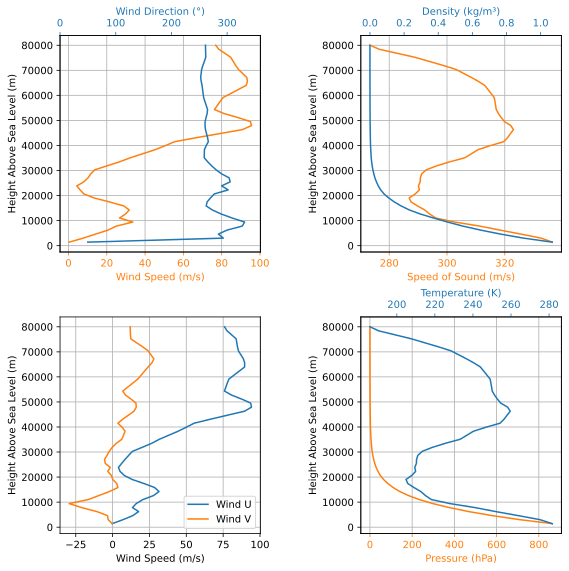

In [5]:
Env.info()

### Creating a Motor

A solid rocket motor is used in this case. See [Solid Motor Class Usage](solid_motor_class_usage.ipynb) for more information on how to use the Motor class.

In [6]:
Pro75M1670 = SolidMotor(
    thrustSource="../../data/motors/Cesaroni_M1670.eng",
    burnOut=3.9,
    grainNumber=5,
    grainSeparation=5 / 1000,
    grainDensity=1815,
    grainOuterRadius=33 / 1000,
    grainInitialInnerRadius=15 / 1000,
    grainInitialHeight=120 / 1000,
    nozzleRadius=33 / 1000,
    throatRadius=11 / 1000,
    interpolationMethod="linear",
)


Motor Details
Total Burning Time: 3.9 s
Total Propellant Mass: 2.956 kg
Propellant Exhaust Velocity: 2038.745 m/s
Average Thrust: 1545.218 N
Maximum Thrust: 2200.0 N at 0.15 s after ignition.
Total Impulse: 6026.350 Ns

Plots


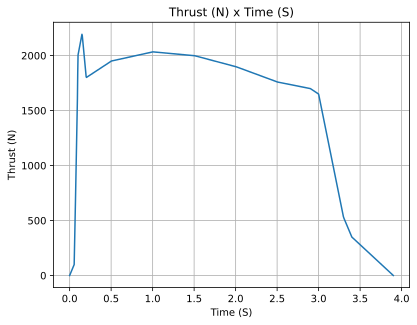

In [7]:
Pro75M1670.info()

## Simulating the First Flight Stage

Let's start to simulate our rocket's flight. We will use the Environment and Motor objects we created before.

We will assume that the payload is be ejected at apogee, however, this can be modified if needed.

We start by defining the value of each relevant mass, ensuring the are correct before continuing.

In [8]:
# 16.241 is the mass of the rocket including the payload but without the propellant
PayloadMass = 4.5  # in kg
RocketMass = 16.241 - PayloadMass  # in kg

print("Rocket dry mass: {:.4} kg (with Payload)".format(RocketMass + PayloadMass))
print("Propellant Mass: {:.4} kg".format(Pro75M1670.mass(0)))
print("Payload Mass: {:.4} kg".format(PayloadMass))
print(
    "Fully loaded Rocket Mass: {:.4} kg".format(
        RocketMass + Pro75M1670.mass(0) + PayloadMass
    )
)

Rocket dry mass: 16.24 kg (with Payload)
Propellant Mass: 2.956 kg
Payload Mass: 4.5 kg
Fully loaded Rocket Mass: 19.2 kg


In [9]:
Rocket1 = Rocket(
    motor=Pro75M1670,
    radius=127 / 2000,
    mass=RocketMass + PayloadMass,
    inertiaI=6.60,
    inertiaZ=0.0351,
    distanceRocketNozzle=-1.255,
    distanceRocketPropellant=-0.85704,
    powerOffDrag="../../data/calisto/powerOffDragCurve.csv",
    powerOnDrag="../../data/calisto/powerOnDragCurve.csv",
)

Rocket1.setRailButtons([0.2, -0.5])

NoseCone_Rocket1 = Rocket1.addNose(
    length=0.55829, kind="vonKarman", distanceToCM=0.71971
)

FinSet_Rocket1 = Rocket1.addFins(
    4, span=0.100, rootChord=0.120, tipChord=0.040, distanceToCM=-1.04956
)

Tail_Rocket1 = Rocket1.addTail(
    topRadius=0.0635, bottomRadius=0.0435, length=0.060, distanceToCM=-1.194656
)

In [10]:
Rocket1.info()


Inertia Details

Rocket Mass: 16.241 kg (No Propellant)
Rocket Mass: 19.197 kg (With Propellant)
Rocket Inertia I: 6.600 kg*m2
Rocket Inertia Z: 0.035 kg*m2


Geometrical Parameters

Rocket Maximum Radius: 0.0635 m
Rocket Frontal Area: 0.012668 m2

Rocket Distances
Rocket Center of Mass - Nozzle Exit Distance: -1.255 m
Rocket Center of Mass - Motor reference point: -0.85704 m
Rocket Center of Mass - Rocket Loaded Center of Mass: -0.132 m

Aerodynamic Components Parameters
Currently not implemented.


Aerodynamics Lift Coefficient Derivatives

Nose Cone Lift Coefficient Derivative: 2.000/rad
Fins Lift Coefficient Derivative: 5.145/rad
Tail Lift Coefficient Derivative: -1.061/rad

Aerodynamics Center of Pressure

Nose Cone Center of Pressure to CM: 0.999 m
Fins Center of Pressure to CM: -1.105 m
Tail Center of Pressure to CM: -1.223 m
Distance - Center of Pressure to CM: -0.392 m
Initial Static Margin: 2.051 c
Final Static Margin: 3.090 c




In [11]:
RocketFlight1 = Flight(
    rocket=Rocket1, environment=Env, inclination=85, heading=25, terminateOnApogee=True, name="RocketFlight1"
)

## Start the Second Flight Stage

Now we will simulate the second flight stage, which is the landing phase of our Rocket.
Here we will consider that the payload was ejected at the apogee of the first stage.
Therefore we should be careful with the value of its mass.

In [12]:
Rocket2 = Rocket(
    motor=Pro75M1670,  # This motor will not be used
    radius=127 / 2000,
    mass=RocketMass,
    inertiaI=6.60,
    inertiaZ=0.0351,
    distanceRocketNozzle=-1.255,
    distanceRocketPropellant=-0.85704,
    powerOffDrag=1,
    powerOnDrag=1,
)


def drogueTrigger(p, y):
    # p = pressure
    # y = [x, y, z, vx, vy, vz, e0, e1, e2, e3, w1, w2, w3]
    # activate drogue when vz < 0 m/s.
    return True if y[5] < 0 else False


def mainTrigger(p, y):
    # p = pressure
    # y = [x, y, z, vx, vy, vz, e0, e1, e2, e3, w1, w2, w3]
    # activate main when vz < 0 m/s and z < 800 + 1400 m (+1400 due to surface elevation).
    return True if y[5] < 0 and y[2] < 800 + 1400 else False


# Define Parachutes for the rocket
Main_Rocket2 = Rocket2.addParachute(
    "Main",
    CdS=7.2,
    trigger=mainTrigger,
    samplingRate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
)

Drogue_Rocket2 = Rocket2.addParachute(
    "Drogue",
    CdS=0.72,
    trigger=drogueTrigger,
    samplingRate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
)

In [13]:
Rocket2.info()


Inertia Details

Rocket Mass: 11.741 kg (No Propellant)
Rocket Mass: 14.697 kg (With Propellant)
Rocket Inertia I: 6.600 kg*m2
Rocket Inertia Z: 0.035 kg*m2


Geometrical Parameters

Rocket Maximum Radius: 0.0635 m
Rocket Frontal Area: 0.012668 m2

Rocket Distances
Rocket Center of Mass - Nozzle Exit Distance: -1.255 m
Rocket Center of Mass - Motor reference point: -0.85704 m
Rocket Center of Mass - Rocket Loaded Center of Mass: -0.172 m

Aerodynamic Components Parameters
Currently not implemented.


Aerodynamics Lift Coefficient Derivatives


Aerodynamics Center of Pressure

Distance - Center of Pressure to CM: 0.000 m
Initial Static Margin: -1.357 c
Final Static Margin: -0.000 c


Main Parachute

CdS Coefficient: 7.2 m2
Ejection signal trigger: mainTrigger
Ejection system refresh rate: 105 Hz.
Time between ejection signal is triggered and the parachute is fully opened: 1.5 s



The magic line `initialSolution=RocketFlight1` will make the simulation start from the end of the first stage.

In [14]:
RocketFlight2 = Flight(
    rocket=Rocket2,
    environment=Env,
    inclination=0,
    heading=0,
    maxTime=600,
    initialSolution=RocketFlight1,
    name="RocketFlight2",
)

## Simulating the 3 Flight Stage - Payload Flight

Here we will simulate the payload flight, which is the third flight stage of our Rocket.
The Payload will be ejected at the apogee of the first stage.
Here, it will be modelled as a "dummy" rocket, which does not have any aerodynamic surfaces to stabilize it, neither a motor which ignites.
It does, however, have parachutes.

In [15]:
# Define the "Payload Rocket"

PayloadRocket = Rocket(
    motor=Pro75M1670,  # This motor will not be used
    radius=127 / 2000,
    mass=PayloadMass,
    inertiaI=6.60,
    inertiaZ=0.0351,
    distanceRocketNozzle=-1.255,
    distanceRocketPropellant=-0.85704,
    powerOffDrag=0.5,
    powerOnDrag=0.5,
)


def drogueTrigger(p, y):
    # p = pressure
    # y = [x, y, z, vx, vy, vz, e0, e1, e2, e3, w1, w2, w3]
    # activate drogue when vz < 0 m/s.
    return True if y[5] < 0 else False


def mainTrigger(p, y):
    # p = pressure
    # y = [x, y, z, vx, vy, vz, e0, e1, e2, e3, w1, w2, w3]
    # activate main when vz < 0 m/s and z < 800 + 1400 m (+1400 due to surface elevation).
    return True if y[5] < 0 and y[2] < 800 + 1400 else False


PayloadDrogue = PayloadRocket.addParachute(
    "Drogue",
    CdS=0.35,
    trigger=drogueTrigger,
    samplingRate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
)

PayloadMain = PayloadRocket.addParachute(
    "Main",
    CdS=4.0,
    trigger=mainTrigger,
    samplingRate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
)

The magic line `initialSolution=RocketFlight1` will make the simulation start from the end of the first stage.

In [16]:
PayloadFlight = Flight(
    rocket=PayloadRocket,
    environment=Env,
    inclination=0,
    heading=0,
    maxTime=600,
    initialSolution=RocketFlight1,
    name="PayloadFlight",
)

## Plotting Everything together

We will invoke a method from RocketPy's utilities class in order to visualize 
the trajectory.

In [17]:
from rocketpy.plots.compare import CompareFlights

Then we create the `comparison` object, an instance of CompareFligths class

In [18]:
comparison = CompareFlights([RocketFlight1, RocketFlight2, PayloadFlight])

And, finally, we are able to plot different aspects of the comparison object.

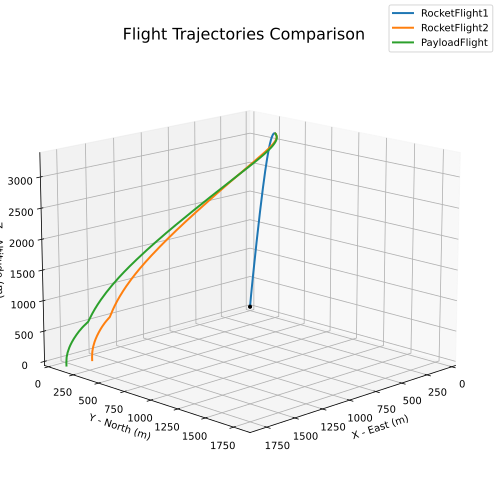

In [24]:
comparison.trajectories_3d(legend=True)

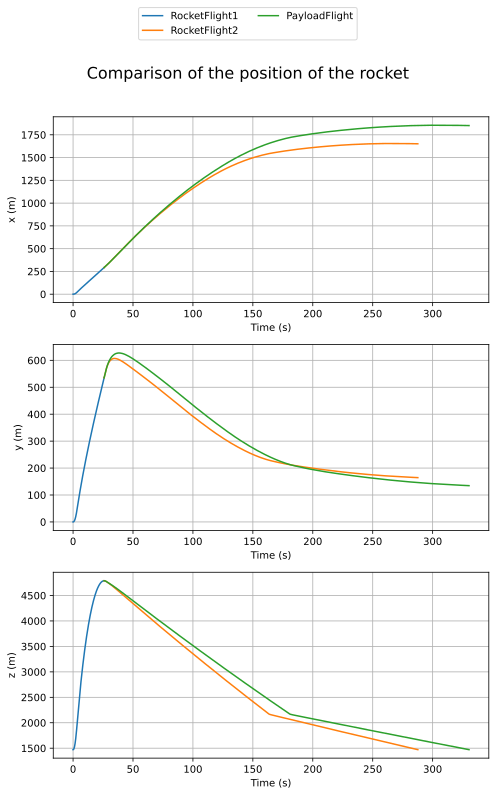

In [27]:
comparison.positions()

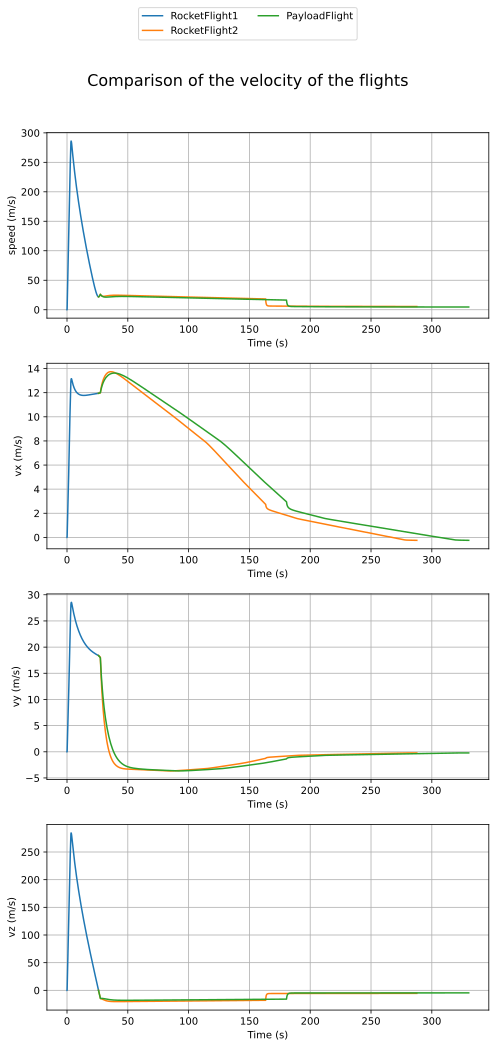

In [28]:
comparison.velocities()

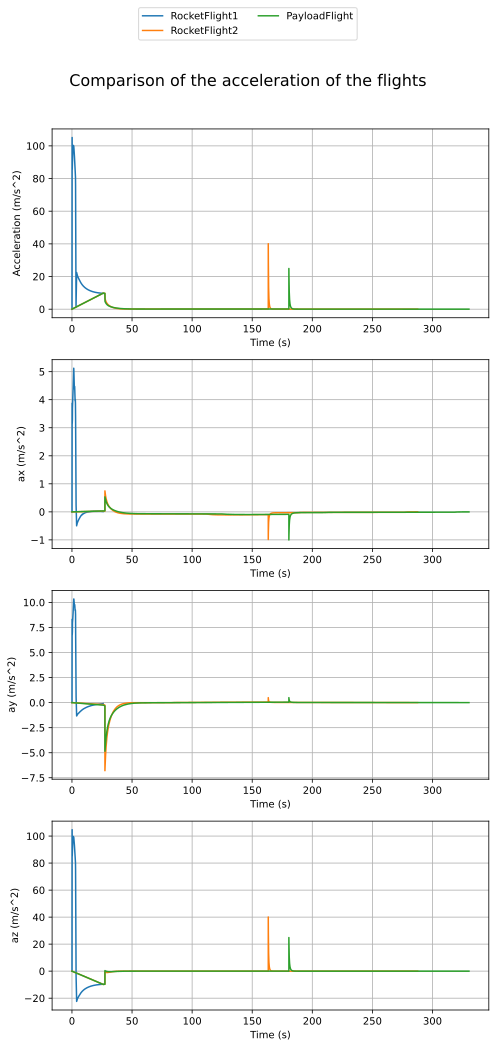

In [26]:
comparison.accelerations()

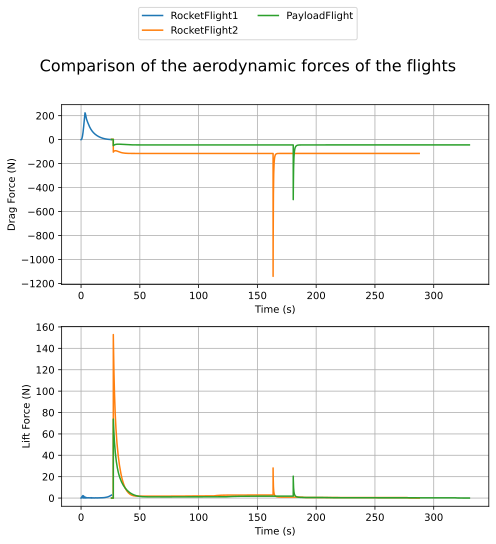

In [29]:
comparison.aerodynamic_forces()

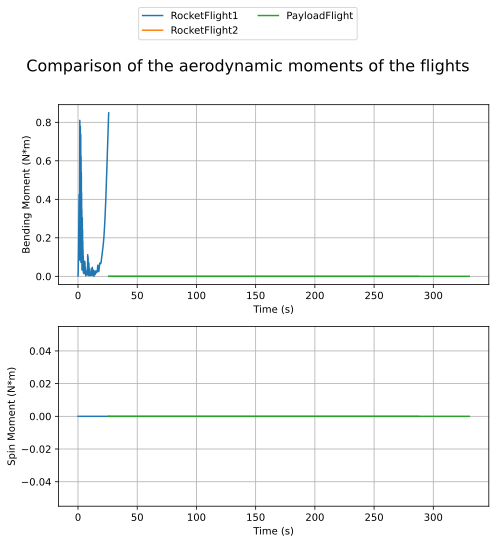

In [32]:
comparison.aerodynamic_moments()

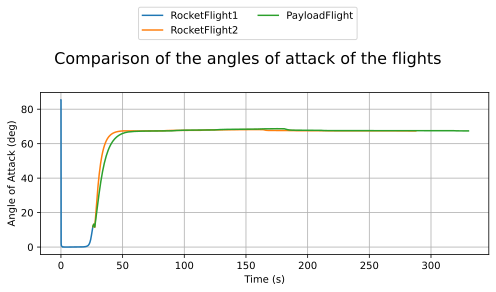

In [33]:
comparison.angles_of_attack()